<a href="https://colab.research.google.com/github/laihowo/HK_Carpark_Vacancy/blob/main/Benny_Model_Park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import os
park_path = 'park'
park_id = '1ScWo16AqK4vbYfAQpSj_I7-fue4sJ2Iu'
if not os.path.exists(park_path):
  !gdown $park_id -O $park_path
  !unzip -q $park_path

Downloading...
From: https://drive.google.com/uc?id=1ScWo16AqK4vbYfAQpSj_I7-fue4sJ2Iu
To: /content/park
100% 6.96M/6.96M [00:00<00:00, 19.5MB/s]


In [ ]:
import json
import requests
info_url = 'https://resource.data.one.gov.hk/td/carpark/basic_info_all.json'
info_json = json.loads(requests.get(info_url).content)
info_df = pd.json_normalize(info_json['car_park'])

In [ ]:
# @title User Input { run: "auto", vertical-output: true }
from datetime import datetime as dt
from IPython.display import display
import panel as pn

district_list = info_df['district_en'].unique()
district_list = sorted(np.delete(district_list, -1))
pn.extension()

parking_district = pn.widgets.Select(name='Parking District', options=district_list)
display(parking_district)

parking_datetime = pn.widgets.DatetimePicker(name='Parking Datetime', value=dt.now(), margin=(20, 0, 350, 10))
display(parking_datetime)

Select(name='Parking District', options=['Central & Western', ...], value='Central & Western')

DatetimePicker(margin=(20, 0, 350, 10), name='Parking Datetime', value=datetime.datetime(2023, ...)

In [ ]:
# @title DataFrame Input { run: "auto", vertical-output: true }

district_df = info_df[info_df['district_en'] == parking_district.value]
park_list = sorted(district_df['name_en'].unique())

park_path = 'park.csv'
park_df_list = []
park_name_list =[]
for item in park_list:
  park_df = pd.DataFrame()
  park_id_input = info_df.loc[info_df['name_en'] == item, 'park_id'].iloc[0]

  for file in sorted(os.listdir(park_path)):
    if file == park_id_input+'.csv':
      park_df = pd.read_csv(park_path + '/' + file)

      # At least 2 records for training data
      if len(park_df) > 1:
        park_df['lastupdate'] = pd.to_datetime(park_df['lastupdate'])
        park_df.set_index('lastupdate', inplace=True)
        park_df_list.append({'id': park_id_input, 'name': item, 'df': park_df})
        park_name_list.append(item)
        break

parking_site = pn.widgets.RadioBoxGroup(options=park_name_list, inline=False)
display(parking_site)

RadioBoxGroup(name='aaa', options=['Hong Kong Tennis Centre'...], value='Hong Kong Tennis Centre')

Wong Nai Chung Gap Children Playground


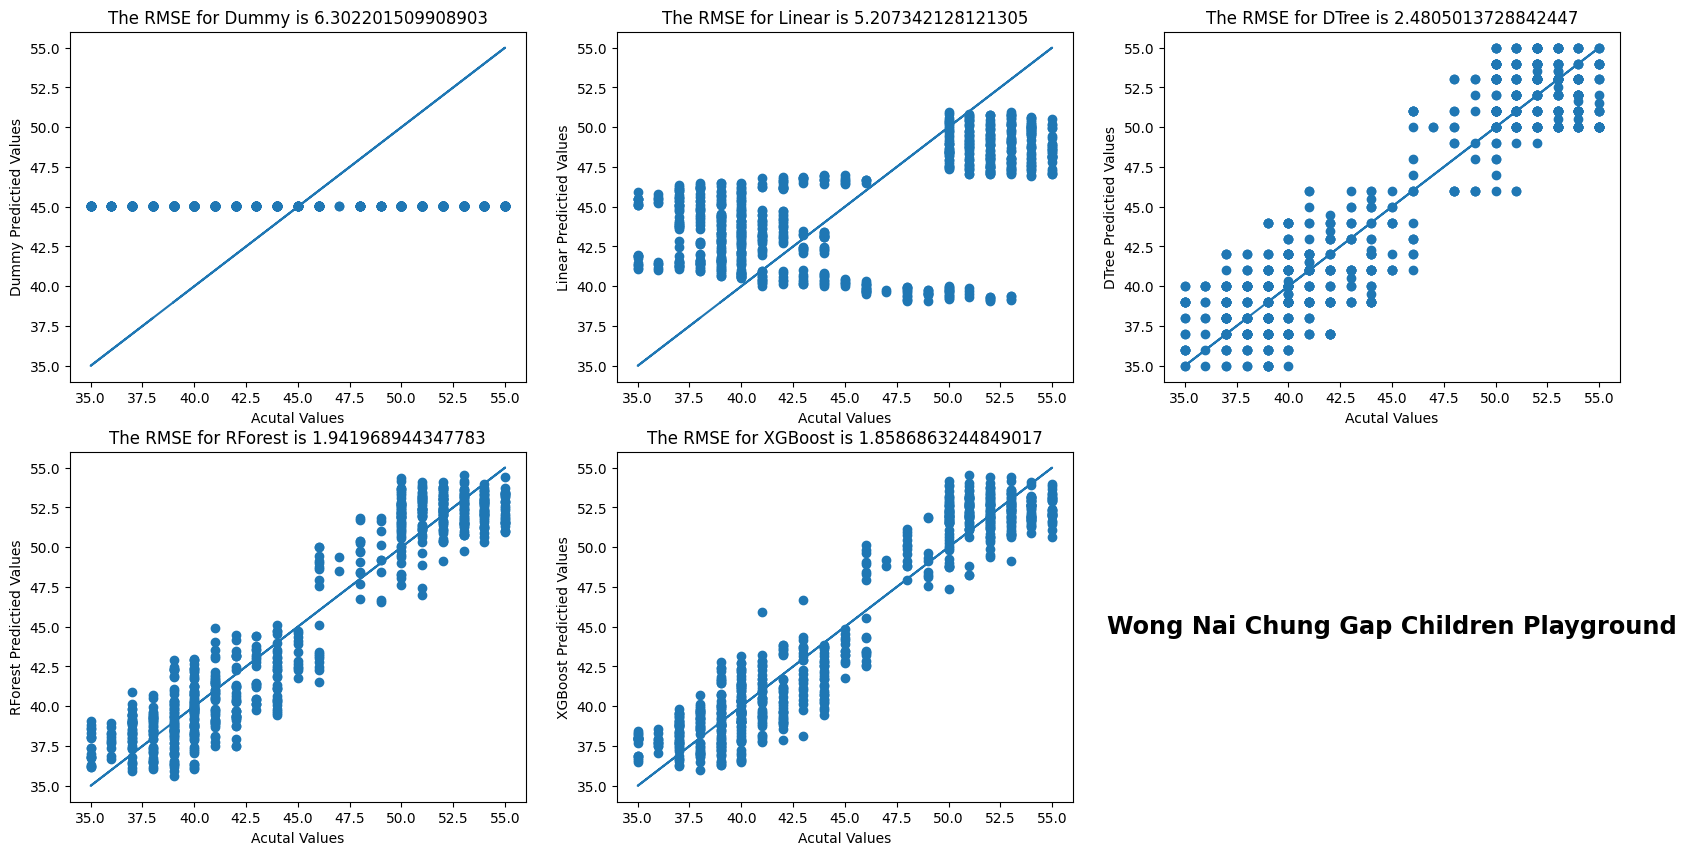

In [ ]:
# @title Car Park Model { run: "auto", vertical-output: true }

# Default Car Park
park_item = park_df_list[0]

# Search for Car Park Input
park_name_input = parking_site.value
print(park_name_input)
for item in park_df_list:
  if item['name'] == park_name_input:
    park_item = item
    break

# Split the data
from sklearn.model_selection import train_test_split

park_df = park_item['df']
if len(park_df) > 1:
  X = park_df[['day_of_week', 'time']]
  y = park_df['vacancy']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

  # Model
  from sklearn.dummy import DummyRegressor
  from sklearn.linear_model import LinearRegression
  from sklearn.tree import DecisionTreeRegressor
  from sklearn.ensemble import RandomForestRegressor
  from xgboost import XGBRegressor

  # Evaluation
  from sklearn.metrics import mean_squared_error

  model_names = ['Dummy', 'Linear', 'DTree', 'RForest', 'XGBoost']
  models = [DummyRegressor, LinearRegression, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor]
  predictions = []

  fig = plt.figure(figsize=(20, 10))
  subplot_column = 2
  subplot_row = 3
  for i, (model_name, model) in enumerate(zip(model_names, models)):
    regressor = model()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    predictions.append([model_name, y_pred])

    ax = fig.add_subplot(subplot_column, subplot_row, i+1)
    ax.plot(y_test, y_test)
    ax.scatter(y_test, y_pred)

    plt.xlabel('Acutal Values')
    plt.ylabel(model_name + ' ' + 'Predictied Values')
    plt.title(f'The RMSE for {model_name} is {np.sqrt(mse)}')

  ax = fig.add_subplot(subplot_column, subplot_row, subplot_column*subplot_row)
  ax.axis('off')

  # Car Park Image
  from PIL import Image
  park_img_url = info_df.loc[info_df['park_id'] == park_item['id'], 'carpark_photo'].iloc[0]
  park_img_path = 'park_img' + '/' + park_img_url.split('/')[-1]

  if not os.path.exists(park_img_path):
    path_prefix = park_img_path.split('/')[0]
    !wget -q -P $path_prefix $park_img_url

  try:
    park_img = Image.open(park_img_path)
    ax.imshow(park_img)
    plt.title(park_name_input)
  except:
    ax.text(0.5, 0.5, park_name_input, size='xx-large', weight='bold', ha='center', va='center')

  plt.show()

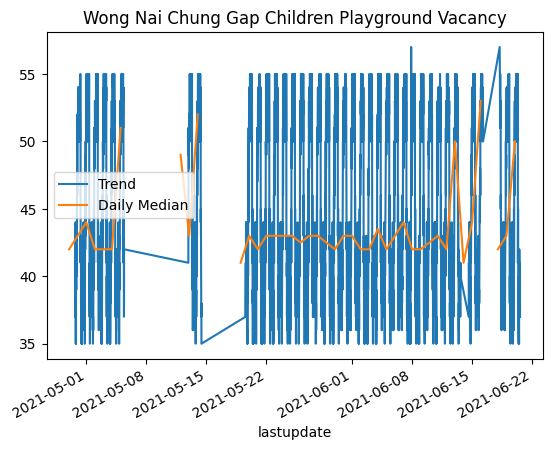

In [ ]:
# Get the daily median of vacancy
daily_median_df = pd.DataFrame(park_df['vacancy'].resample('1D').median())
park_df['vacancy'].plot()
daily_median_df['vacancy'].plot()
plt.title(park_name_input + ' Vacancy')
plt.legend(['Trend', 'Daily Median'])

In [ ]:
# The percentage of the RMSE to the mean of the median of the vacancy in 1 day
# The RMSE is around 10% of the median of the number of vacancy
# mse = mse for the last model
ratio = np.sqrt(mse) / daily_median_df['vacancy'].mean() * 100
ratio

4.247270164764194

In [ ]:
from sklearn.metrics import r2_score

for item in predictions:
  print('R2_' + item[0] + ': ' + str(r2_score(y_test, item[1])))

R2_Dummy: -2.0064854925561093e-05
R2_Linear: 0.3172583968033478
R2_DTree: 0.8450815701522677
R2_RForest: 0.9050469970685089
R2_XGBoost: 0.9130166058183703


In [ ]:
# Create a dataframe for input datetime
dt_input = parking_datetime.value
time = dt_input.hour + dt_input.minute / 60 + dt_input.second / 3600
dt_input_df = pd.DataFrame(columns=['day_of_week', 'time'])
dt_input_df.loc[0] = [dt_input.weekday(), time]
dt_input_df

,day_of_week,time
0,5.0,20.060833


In [ ]:
def train_data(park_df, dt_input_df):
  X = park_df[['day_of_week', 'time']]
  y = park_df['vacancy']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
  xgb_model = XGBRegressor()
  xgb_model.fit(X_train, y_train)
  predict = xgb_model.predict(dt_input_df)
  return predict

ranking_df = pd.DataFrame(columns=['Park_Name', 'Predicted_Vacancy'])
for park in park_df_list:
  if len(park['df']) > 1:
    vacancy_pred = train_data(park['df'], dt_input_df)
    ranking_df.loc[park['id']] = [park['name'], vacancy_pred]
  else:
    continue

# Sorted for ranking
ranking_df = ranking_df.sort_values(by=['Predicted_Vacancy'], ascending=False)
print('We suggest you to park at\n')
print(ranking_df)

We suggest you to park at

                                      Park_Name Predicted_Vacancy
tdcp11                         Tin Hau Car Park        [88.65672]
tdc1p3                        Leighton Car Park       [41.739166]
tdc58p1  Wong Nai Chung Gap Children Playground         [38.1384]
tdc1p5                Lee Garden Three Car Park       [37.520557]
tdc1p2                  Lee Garden Two Car Park        [35.29781]
tdc1p1                  Lee Garden One Car Park       [20.874968]
tdc38p1                 Hong Kong Tennis Centre       [18.714808]
tdc1p4                     Hysan Place Car Park       [12.453767]
